In [1]:
import xarray as xr
import numpy as np
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

# "import *" is poor form, but I was lazy
from turbulence_AUSCAT.auscat_plots import *

# combined_significance_table is very slow and not at all parallelised. Need to be smarter so it can be run on dask
from turbulence_AUSCAT.cat_evaluation import combined_significance_table, time_sel_dict, calc_trend_table, select_resample_time

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
from glob import glob
from scipy import stats
from xarray.groupers import SeasonResampler, SeasonGrouper
import os

import dask
from dask.distributed import Client
# request 14 cores 64GB


In [2]:
mid_lat_slice = slice(-50,-25)
lon_slice = slice(90,195)
baseline_time_range = np.arange(1990,2009+1)
baseline_time_slice = slice("1990", "2009")

time_slices = [("2015", "2034"), 
              ("2040", "2059"),
              ("2080", "2099"),
              ]


In [3]:
# ssp_colors = {"evaluation":"k",
#               "historical":"grey",
#               "ssp585":(149/255,27/255,30/255),
#               "ssp370":(231/255,29/255,37/255),
#               "ssp245":(247/255,148/255,32/255),
#               "ssp126":(23/255,60/255,102/255),
#               "ssp119":(0/255,173/255,207/255),}

In [4]:
list_evaluation = ['evaluation_BARRA-R_r1i1p1f1',
                  ]

list_historical = ['historical_ACCESS-CM2_r4i1p1f1', 
                   'historical_ACCESS-ESM1-5_r6i1p1f1',
                   'historical_CESM2_r11i1p1f1', 
                   'historical_CMCC-ESM2_r1i1p1f1',
                   'historical_EC-Earth3_r1i1p1f1',
                   'historical_MPI-ESM1-2-HR_r1i1p1f1',
                   'historical_NorESM2-MM_r1i1p1f1',
                  ]

list_ssp126 = [
                 'ssp126_ACCESS-CM2_r4i1p1f1',
                 'ssp126_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp126_CESM2_r11i1p1f1',
                 'ssp126_CMCC-ESM2_r1i1p1f1',
                 'ssp126_EC-Earth3_r1i1p1f1',
                 'ssp126_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp126_NorESM2-MM_r1i1p1f1',
              ]

list_ssp370 = ['ssp370_ACCESS-CM2_r4i1p1f1',
                 'ssp370_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp370_CESM2_r11i1p1f1',
                 'ssp370_CMCC-ESM2_r1i1p1f1',
                 'ssp370_EC-Earth3_r1i1p1f1',
                 'ssp370_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp370_NorESM2-MM_r1i1p1f1',
              ]

list_ssp585 = ['ssp585_ACCESS-CM2_r4i1p1f1',
                 'ssp585_EC-Earth3_r1i1p1f1']

list_future = list_ssp126 + list_ssp370 + list_ssp585

In [5]:
def run_all_plots_and_tables(turbulence_index, P, window_size = 10, time_slices=time_slices):
    """ Function for all the plots and tables for specified turbulence index and pressure level P.
    window specifies the rolling window for time series plots. Time slices specifies the list of 
    (three) start/end year slices for plot_futures futre decades plots"""
    #  ------------------  make evaluation table ----------------------------
    # Evaluate the models compared to BARRA-R for a baseline period of 1990 to 2009
    
    path=f"/scratch/v46/gt3409"
    outfile = f"{path}/{turbulence_index}/{P}hPa/evaluation_combined_tests_table_{turbulence_index}-{P}hPa.csv"
    
    if  os.path.exists(outfile):
        print(f"File '{outfile}' already exists.")
    else:
        with Client(threads_per_worker=4, n_workers=1) as client:
            combined_significance_table(turbulence_index, P, path=path)

    # ----------------- evaluate baseline period ------------------------------
    filelist = glob(f"/scratch/v46/gt3409/{turbulence_index}/{P}hPa/freq-above-p99/{turbulence_index}-{P}hPa-monthly-freq-above-p99_AUS-15_*.nc")
    ds = xr.open_mfdataset(filelist, 
                           combine="nested",
                           concat_dim="run",
                           join='outer', 
                           coords='different',
                          compat='no_conflicts')
    ds = ds.assign_coords({"pressure":[P]})

    # --------------------------- Baseline maps per model -----------------
    with Client(threads_per_worker=4, n_workers=1) as client:
        ds_baseline_mapped = ds.isel({'pressure':0}).sel({"time":baseline_time_slice, 
                                                              # "lat":mid_lat_slice,
                                                              "lon": lon_slice}).resample({"time":"YE"}).mean()
    
        
        evaluate_model_map(ds_baseline_mapped, turbulence_index, P)
        evaluate_model_map_anom(ds_baseline_mapped, turbulence_index, P)

    # ----------------------- Dataset time series ------------------
    # weighted for latitudes
    weights = np.cos(np.deg2rad(ds[turbulence_index].lat))
    weights.name = "weights"
    
    ds_ts  = ds.sel({"lat":mid_lat_slice, 
                     "lon": lon_slice,
                     "run":list_evaluation+list_historical+list_future
                    }).weighted(weights).mean(["lat", "lon"]).load()

    # ----------------------- calculate table
    outfile = f"/scratch/v46/gt3409/{turbulence_index}/{P}hPa/Trend_table_{turbulence_index}_{P}hPa_Frequency_of_exceeding_p99.csv" 
    
    if  os.path.exists(outfile):
        print(f"File '{outfile}' already exists.")
    else:
        calc_trend_table(ds_ts, turbulence_index, P, outfile=outfile,)

    # ------------------------ Time series plots
    # "turbulence_index": [annual max, seasonal max, monthly max]
    ymax_dict = {"windspeed": [0.05, 0.08, 0.12],
                 "VWS": [0.022, 0.24, 0.24],
                 "TI1": [0.014, 0.025, 0.025],
                }

    plot_timeseries_annual(ds_ts, turbulence_index, P, window_size, ymax=ymax_dict[turbulence_index][0])
    plot_timeseries_annual(ds_ts, turbulence_index, P, window_size=1, ymax=ymax_dict[turbulence_index][0])
    plot_timeseries_coolwarmseason(ds_ts, turbulence_index, P, window_size, ymax=ymax_dict[turbulence_index][1])   
    plot_timeseries_season(ds_ts, turbulence_index, P, window_size, ymax=ymax_dict[turbulence_index][1])
    plot_timeseries_month(ds_ts, turbulence_index, P, window_size, ymax=ymax_dict[turbulence_index][2])

    # ----------------------  maps
    evaluation = list_evaluation[0]
    filelist = [f"/scratch/v46/gt3409/{turbulence_index}/{P}hPa/freq-above-p99/{turbulence_index}-{P}hPa-monthly-freq-above-p99_AUS-15_{run}_BOM_BARPA-R_v1-r1_6hr.nc" 
                            for run in [evaluation] + list_historical]
    ds = xr.open_mfdataset(filelist,
                          concat_dim="run",
                          combine="nested",
                          join="outer",
                          coords='different',
                          compat='no_conflicts').sel({"lon":lon_slice, "time": baseline_time_slice})
    
    ds_hist = ds.sel({"run":list_historical})
    ds_eval=ds.sel({"run":evaluation}).load()

    # ------------ baseline climatology
    plot_baseline_ann(ds_eval, turbulence_index, P, ticks_max=0.07)   
    plot_baseline_coolwarmseason(ds_eval, turbulence_index, P,ticks_max=0.07)
    plot_baseline_season(ds_eval, turbulence_index, P,ticks_max=0.07)
    plot_baseline_months(ds_eval, turbulence_index, P,ticks_max=0.07)

    # ------------- future maps
    with Client(threads_per_worker=5, n_workers=2) as client:
        plt.close()
        
        for time_selection in ["MJJASO", "annual",]:
            for experiment in ["ssp126", "ssp370", "ssp585"]:
                if experiment == "ssp585":
                    # because there are only two
                    all_agree_except = 0
                else:
                    all_agree_except = 1
                outfile = f"/scratch/v46/gt3409/{turbulence_index}/{P}hPa/Future_decades_{turbulence_index}_{P}hPa_change_in_frequency_of_exceeding_p99_{experiment}_{time_selection}_3timeslices.png"
                if  os.path.exists(outfile):
                    print(f"File '{outfile}' already exists.")
                    continue
                try:
                    plot_futures(time_selection=time_selection, 
                                 turbulence_index=turbulence_index,
                                 time_slices=time_slices,
                                 experiment=experiment, 
                                 all_agree_except=all_agree_except, 
                                 save_fig=True,
                                 outfile = outfile,
                                 zonal_plots=True,
                                 ticks_max=0.02,
                                 P=P
                                    )
                  
                except:
                    print(f"problem making '{outfile}'.")

                try:
                    outfile = f"/scratch/v46/gt3409/{turbulence_index}/{P}hPa/Future_decades_{turbulence_index}_{P}hPa_change_in_frequency_of_exceeding_p99_{experiment}_{time_selection}_baseline-plus-3timeslices.png"
                    plot_futures_1plus3(time_selection=time_selection, 
                                        turbulence_index=turbulence_index,
                                        P=P,
                                        time_slices=[baseline_time_slice] + time_slices,
                                        experiment=experiment, 
                                        all_agree_except=all_agree_except, 
                                        save_fig=True,
                                        outfile = outfile,
                                        ticks_max=0.02,
                                        )
                except:
                    print(f"problem making '{outfile}'.")

            
    # --------------------- combine significance table -----------------
    
    combined_significance_table_file= (f"/scratch/v46/gt3409/{turbulence_index}/{P}hPa/evaluation_combined_tests_table_{turbulence_index}-{P}hPa.csv")
    if  os.path.exists(combined_significance_table_file):
        print(f"File '{combined_significance_table_file}' already exists.")
    else:
        with Client(threads_per_worker=12, n_workers=1) as client:
            combined_significance_table(turbulence_index, P,)
            print(f"Made '{combined_significance_table_file}'")

    return

In [ ]:
%%time
for turbulence_index in ["windspeed", "VWS", "TI1"]:
    for P in [200, 250]:
        run_all_plots_and_tables(turbulence_index, P, window_size = 10)
        plt.close('all')

File '/scratch/v46/gt3409/windspeed/200hPa/evaluation_combined_tests_table_windspeed-200hPa.csv' already exists.
Made /scratch/v46/gt3409/windspeed/200hPa/Evaluation_windspeed_200hPa_frequency_of_exceeding_p99_historical_annual_1990-2009.png
Made /scratch/v46/gt3409/windspeed/200hPa/Evaluation_windspeed_200hPa_Difference_in_frequency_of_exceeding_p99_from_BARRA-R_historical_annual_1990-2009.png
File '/scratch/v46/gt3409/windspeed/200hPa/Trend_table_windspeed_200hPa_Frequency_of_exceeding_p99.csv' already exists.
Saved /scratch/v46/gt3409/windspeed/200hPa/Timeseries_windspeed_200hPa_Frequency_of_exceeding_p99_over_time_annual_rolling10y.png
Saved /scratch/v46/gt3409/windspeed/200hPa/Timeseries_windspeed_200hPa_Frequency_of_exceeding_p99_over_time_annual_rolling1y.png
Saved /scratch/v46/gt3409/windspeed/200hPa/Timeseries_windspeed_200hPa_Frequency_of_exceeding_p99_over_time_6Mseason_rolling10y.png
DJF
MAM
JJA
SON
Saved /scratch/v46/gt3409/windspeed/200hPa/Timeseries_windspeed_200hPa_Freq

/home/563/gt3409/turbulence_AUSCAT/auscat_plots.py:3051: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs1[i+1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), )


problem making '/scratch/v46/gt3409/windspeed/200hPa/Future_decades_windspeed_200hPa_change_in_frequency_of_exceeding_p99_ssp126_MJJASO_baseline-plus-3timeslices.png'.
Saved /scratch/v46/gt3409/windspeed/200hPa/Future_decades_windspeed_200hPa_change_in_frequency_of_exceeding_p99_ssp370_MJJASO_3timeslices.png


/home/563/gt3409/turbulence_AUSCAT/auscat_plots.py:3051: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs1[i+1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), )


problem making '/scratch/v46/gt3409/windspeed/200hPa/Future_decades_windspeed_200hPa_change_in_frequency_of_exceeding_p99_ssp370_MJJASO_baseline-plus-3timeslices.png'.
Saved /scratch/v46/gt3409/windspeed/200hPa/Future_decades_windspeed_200hPa_change_in_frequency_of_exceeding_p99_ssp585_MJJASO_3timeslices.png


/home/563/gt3409/turbulence_AUSCAT/auscat_plots.py:3051: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs1[i+1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), )
[gadi-cpu-bdw-0010:3419157:0:3419157] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x41)
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwar

# see below for figure outputs. Don't need to run

# start the calculations loops from here

In [6]:
turbulence_index = "TI1"
P=250

In [7]:
# make evaluation table
# Evaluate the models compared to BARRA-R for a baseline period of 1990 to 2009

path=f"/scratch/v46/gt3409"
outfile = f"{path}/{turbulence_index}/{P}hPa/evaluation_combined_tests_table_{turbulence_index}-{P}hPa.csv"

if  os.path.exists(outfile):
    print(f"File '{outfile}' already exists.")
else:
    with Client(threads_per_worker=4, n_workers=1) as client:
        combined_significance_table(turbulence_index, P, path=path)

File '/scratch/v46/gt3409/TI1/250hPa/evaluation_combined_tests_table_TI1-250hPa.csv' already exists.


# Evaluate baseline period

In [8]:
filelist = glob.glob(f"/scratch/v46/gt3409/{turbulence_index}/{P}hPa/freq-above-p99/{turbulence_index}-{P}hPa-monthly-freq-above-p99_AUS-15_*.nc")
ds = xr.open_mfdataset(filelist, 
                       combine="nested",
                       concat_dim="run",
                       join='outer', 
                       coords='different',
                      compat='no_conflicts')
ds = ds.assign_coords({"pressure":[P]})

Made /scratch/v46/gt3409/TI1/250hPa/Evaluation_TI1_250hPa_frequency_of_exceeding_p99_historical_annual_1990-2009.png
Made /scratch/v46/gt3409/TI1/250hPa/Evaluation_TI1_250hPa_Difference_in_frequency_of_exceeding_p99_from_BARRA-R_historical_annual_1990-2009.png
CPU times: user 7min 27s, sys: 54.7 s, total: 8min 22s
Wall time: 9min 13s


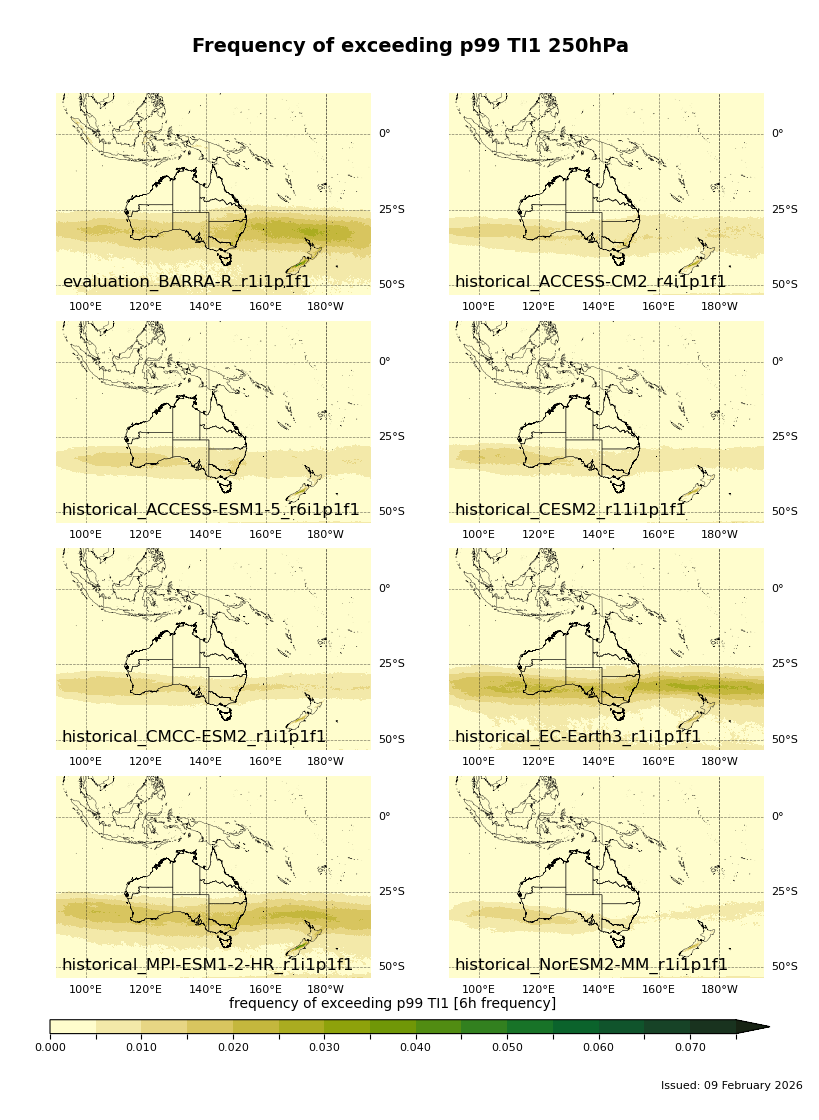

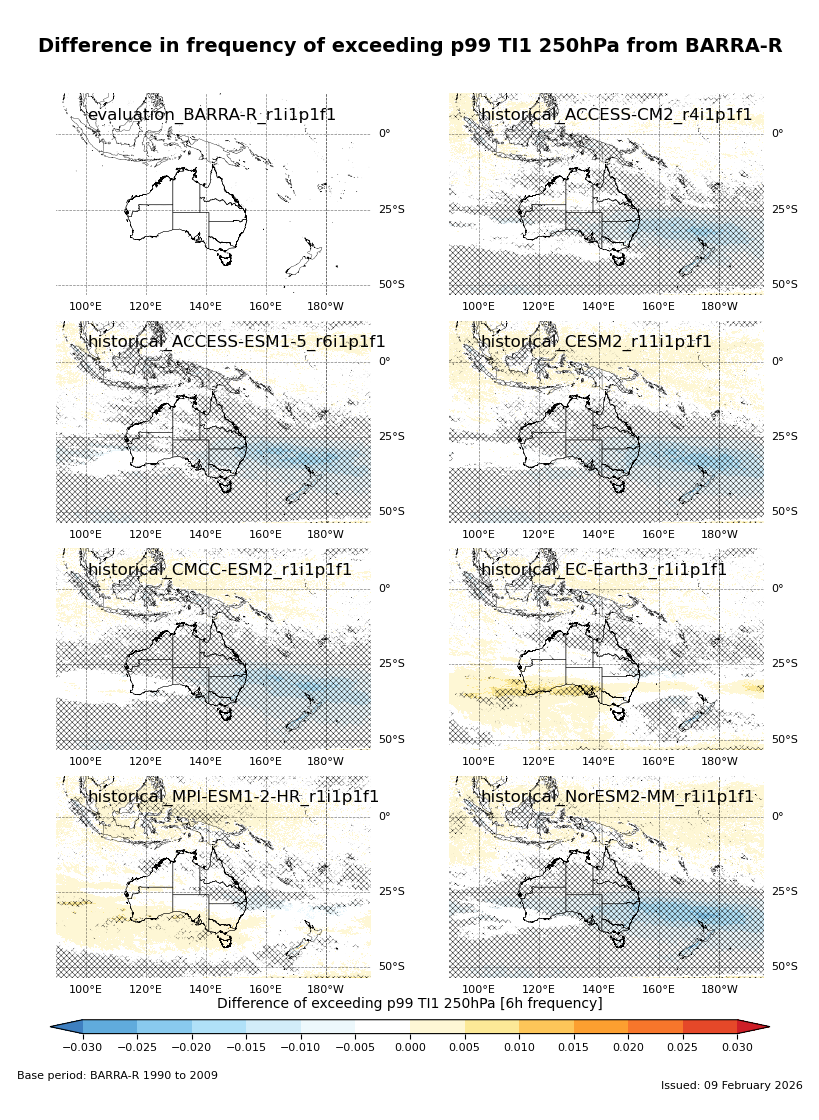

In [9]:
%%time
with Client(threads_per_worker=4, n_workers=1) as client:
    ds_baseline_mapped = ds.isel({'pressure':0}).sel({"time":baseline_time_slice, 
                                                          # "lat":mid_lat_slice,
                                                          "lon": lon_slice}).resample({"time":"YE"}).mean()

    
    evaluate_model_map(ds_baseline_mapped, turbulence_index, P)
    evaluate_model_map_anom(ds_baseline_mapped, turbulence_index, P)


# Time series

In [10]:
%%time
# Dataset time series
# weighted for latitudes
weights = np.cos(np.deg2rad(ds[turbulence_index].lat))
weights.name = "weights"

ds_ts  = ds.sel({"lat":mid_lat_slice, 
                 "lon": lon_slice,
                 "run":list_evaluation+list_historical+list_future
                }).weighted(weights).mean(["lat", "lon"]).load()
ds_ts

CPU times: user 1min 22s, sys: 2min 21s, total: 3min 44s
Wall time: 1min 28s


<xarray.Dataset> Size: 296kB
Dimensions:  (time: 1464, run: 24)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1979-01-31 1979-02-28 ... 2100-12-31
  * run      (run) <U33 3kB 'evaluation_BARRA-R_r1i1p1f1' ... 'ssp585_EC-Eart...
Data variables:
    TI1      (run, time) float64 281kB nan nan nan ... 0.003429 0.003394

In [11]:
# calculate table

outfile = f"/scratch/v46/gt3409/{turbulence_index}/{P}hPa/Trend_table_{turbulence_index}_{P}hPa_Frequency_of_exceeding_p99.csv" 

if  os.path.exists(outfile):
    print(f"File '{outfile}' already exists.")
else:
    calc_trend_table(ds_ts, turbulence_index, P, outfile=outfile,)


File '/scratch/v46/gt3409/TI1/250hPa/Trend_table_TI1_250hPa_Frequency_of_exceeding_p99.csv' already exists.


In [12]:
window_size = 10

using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_MPI-ESM1-2-HR_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
Saved /scratch/v46/gt3409/TI1/250hPa/Timeseries_TI1_250hPa_Frequency_of_exceeding_p99_over_time_annual_rolling10y.png
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_MPI-ESM1-2-HR_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
Saved /scratch/v46/gt3409/TI1/250hPa/Timeseries_TI1_250hPa_Frequency_of_exceeding_p99_over_time_annual_rolling1y.png


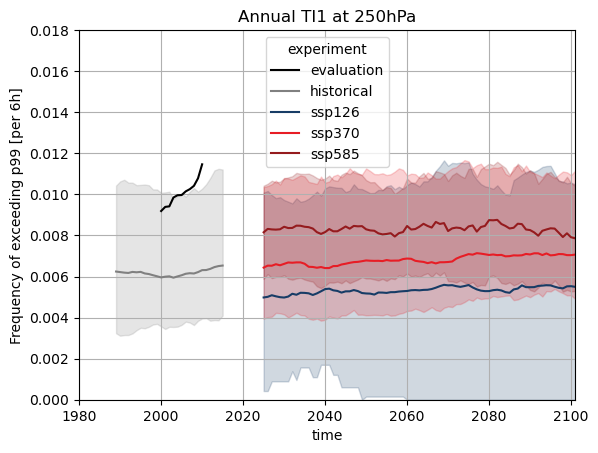

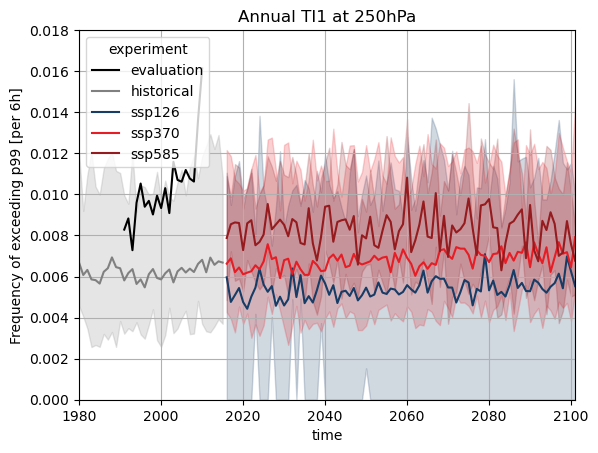

In [13]:
plot_timeseries_annual(ds_ts, turbulence_index, P, window_size, ymax=0.018), 
plot_timeseries_annual(ds_ts, turbulence_index, P, window_size=1, ymax=0.018)


using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_MPI-ESM1-2-HR_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_MPI-ESM1-2-HR_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
Saved /scratch/v46/gt3409/TI1/250hPa/Timeseries_TI1_250hPa_Frequency_of_exceeding_p99_over_time_6Mseason_rolling10y.png
DJF
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_MPI-ESM1-2-HR_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
MAM
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f

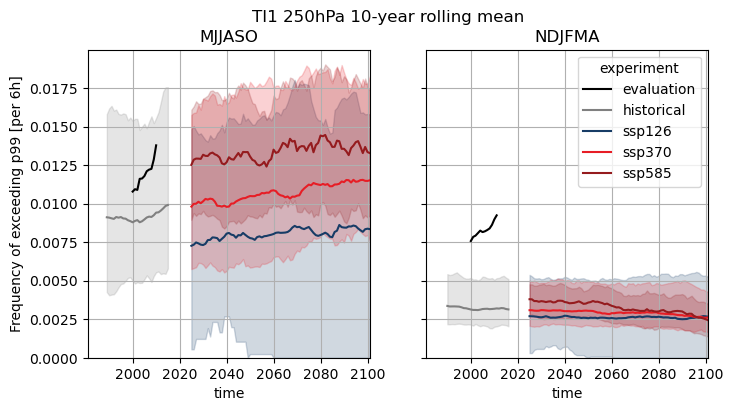

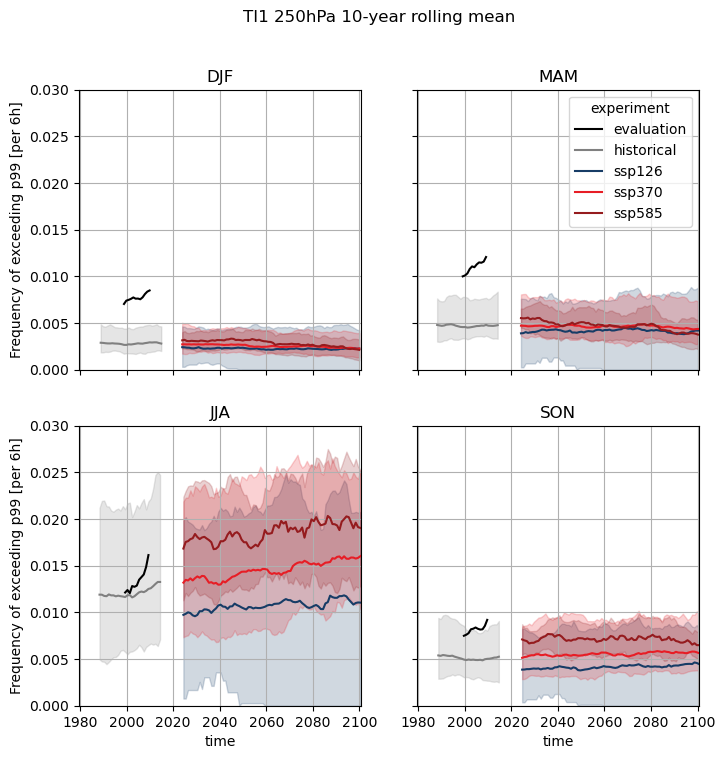

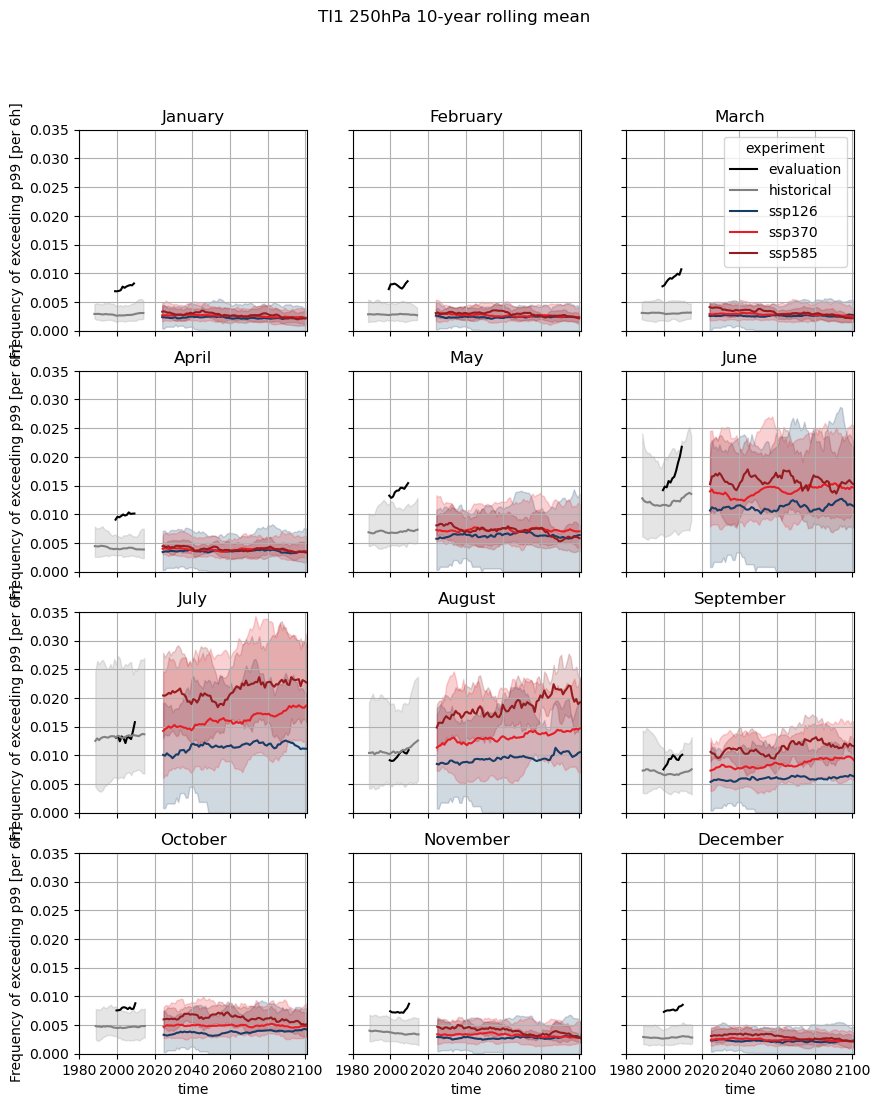

In [14]:
plot_timeseries_coolwarmseason(ds_ts, turbulence_index, P, window_size, ymax=None)   
plot_timeseries_season(ds_ts, turbulence_index, P, window_size, ymax=0.03)
plot_timeseries_month(ds_ts, turbulence_index, P, window_size, ymax=0.035)

# maps

In [15]:
evaluation = list_evaluation[0]
filelist = [f"/scratch/v46/gt3409/{turbulence_index}/{P}hPa/freq-above-p99/{turbulence_index}-{P}hPa-monthly-freq-above-p99_AUS-15_{run}_BOM_BARPA-R_v1-r1_6hr.nc" 
                        for run in [evaluation] + list_historical]
ds = xr.open_mfdataset(filelist,
                      concat_dim="run",
                      combine="nested",
                      join="outer",
                      coords='different',
                      compat='no_conflicts').sel({"lon":lon_slice, "time": baseline_time_slice})

ds_hist = ds.sel({"run":list_historical})
ds_eval=ds.sel({"run":evaluation}).load()



Saved /scratch/v46/gt3409/TI1/250hPa/Evaluation_TI1_250hPa_Frequency_of_exceeding_p99_evaluation_annual_1990-2009.png
Saved /scratch/v46/gt3409/TI1/250hPa/Evaluation_TI1_250hPa_Frequency_of_exceeding_p99_historical_6Mseason_1990-2009.png
Saved /scratch/v46/gt3409/TI1/250hPa/Evaluation_TI1_250hPa_Frequency_of_exceeding_p99_historical_season_1990-2009.png
Saved /scratch/v46/gt3409/TI1/250hPa/Evaluation_TI1_250hPa_Frequency_of_exceeding_p99_historical_month_1990-2009.png
CPU times: user 27.7 s, sys: 4.15 s, total: 31.9 s
Wall time: 31.9 s


(<Figure size 800x800 with 14 Axes>,
 array([[<GeoAxes: >, <GeoAxes: >, <GeoAxes: >],
        [<GeoAxes: >, <GeoAxes: >, <GeoAxes: >],
        [<GeoAxes: >, <GeoAxes: >, <GeoAxes: >],
        [<GeoAxes: >, <GeoAxes: >, <GeoAxes: >]], dtype=object))

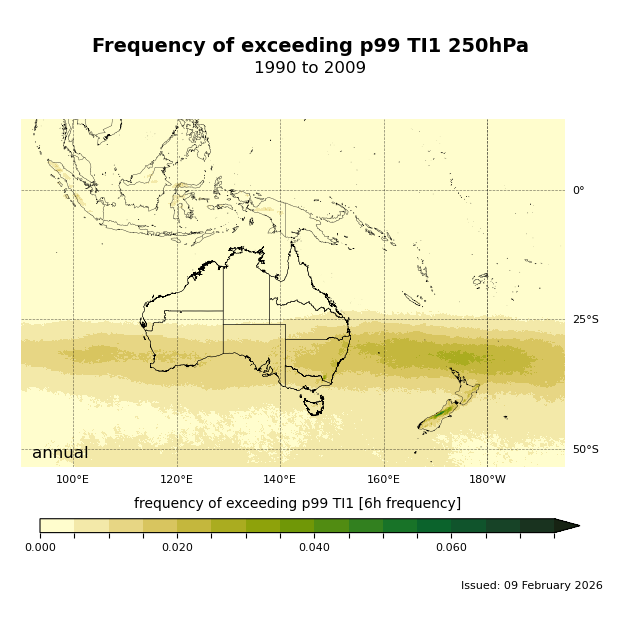

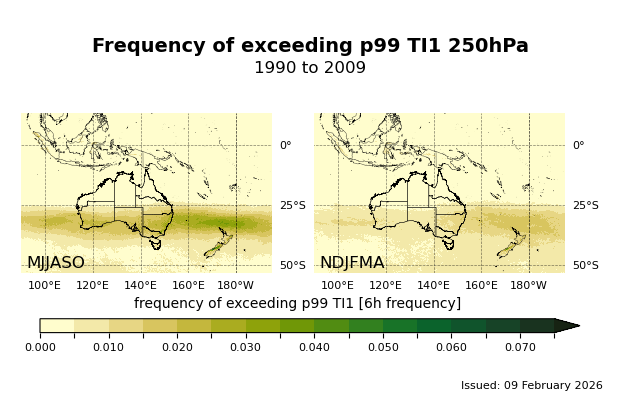

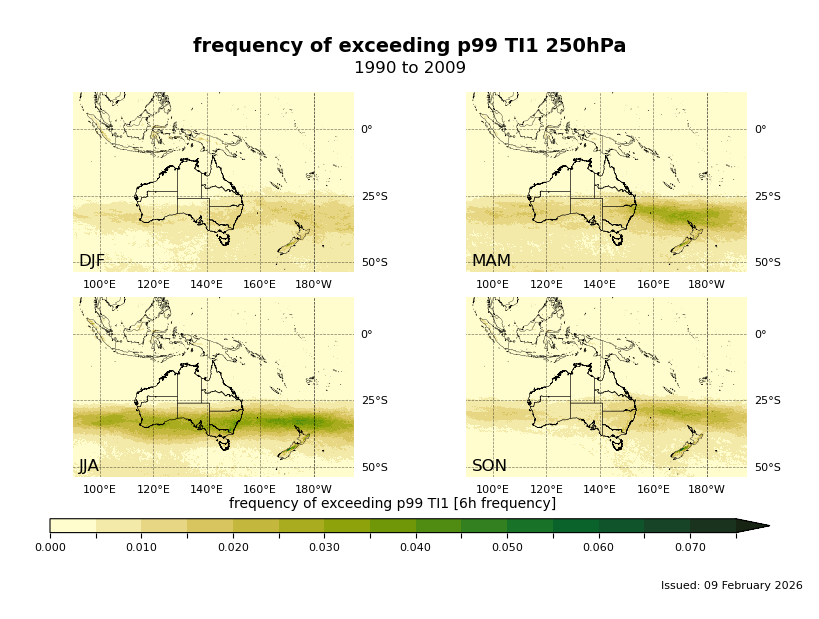

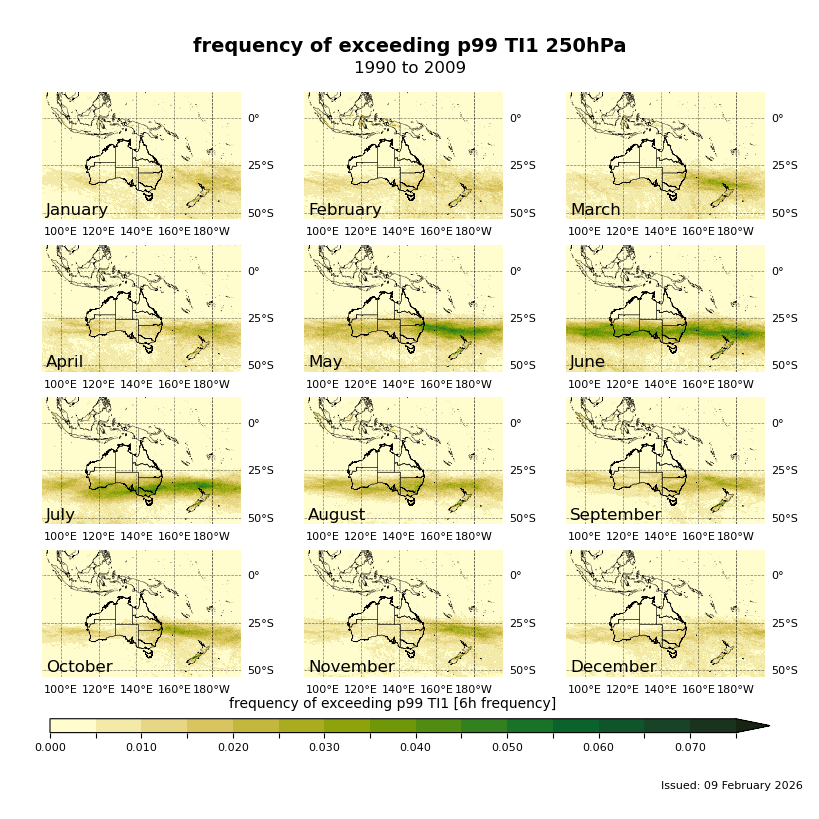

In [16]:
%%time
# annual
plot_baseline_ann(ds_eval, turbulence_index, P, ticks_max=0.08)   
plot_baseline_coolwarmseason(ds_eval, turbulence_index, P,ticks_max=0.08)
plot_baseline_season(ds_eval, turbulence_index, P,ticks_max=0.08)
plot_baseline_months(ds_eval, turbulence_index, P,ticks_max=0.08)

# time evolution of mapped indices


In [17]:
%%time
with Client(threads_per_worker=5, n_workers=2) as client:
    plt.close()
    time_slices = [("2015", "2034"), 
                  ("2040", "2059"),
                  ("2080", "2099"),
                  ]
    # for turbulence_index in ["VWS", "windspeed"]:
    #     for P in ["200", "250"]:
    for time_selection in ["MJJASO", "annual",]:
        for experiment in ["ssp126", "ssp370", "ssp585"]:
            if experiment == "ssp585":
                # because there are only two
                all_agree_except = 0
            else:
                all_agree_except = 1
            outfile = f"/scratch/v46/gt3409/{turbulence_index}/{P}hPa/Future_decades_{turbulence_index}_{P}hPa_change_in_frequency_of_exceeding_p99_{experiment}_{time_selection}_3timeslices.png"
            if  os.path.exists(outfile):
                print(f"File '{outfile}' already exists.")
                continue
            try:
                plot_futures(time_selection=time_selection, 
                             turbulence_index=turbulence_index,
                                 time_slices=time_slices,
                                 experiment=experiment, 
                                 all_agree_except=all_agree_except, 
                                 save_fig=True,
                                 outfile = outfile,
                                 zonal_plots=True,
                                 ticks_max=0.02,
                                )
            except:
                print(f"problem making '{outfile}'.")


File '/scratch/v46/gt3409/TI1/250hPa/Future_decades_TI1_250hPa_change_in_frequency_of_exceeding_p99_ssp126_MJJASO_3timeslices.png' already exists.
File '/scratch/v46/gt3409/TI1/250hPa/Future_decades_TI1_250hPa_change_in_frequency_of_exceeding_p99_ssp370_MJJASO_3timeslices.png' already exists.
File '/scratch/v46/gt3409/TI1/250hPa/Future_decades_TI1_250hPa_change_in_frequency_of_exceeding_p99_ssp585_MJJASO_3timeslices.png' already exists.
problem making '/scratch/v46/gt3409/TI1/250hPa/Future_decades_TI1_250hPa_change_in_frequency_of_exceeding_p99_ssp126_annual_3timeslices.png'.
problem making '/scratch/v46/gt3409/TI1/250hPa/Future_decades_TI1_250hPa_change_in_frequency_of_exceeding_p99_ssp370_annual_3timeslices.png'.
problem making '/scratch/v46/gt3409/TI1/250hPa/Future_decades_TI1_250hPa_change_in_frequency_of_exceeding_p99_ssp585_annual_3timeslices.png'.
CPU times: user 80.7 ms, sys: 52.2 ms, total: 133 ms
Wall time: 1.06 s


In [18]:
# %%time
with Client(threads_per_worker=12, n_workers=1) as client:
    # for turbulence_index in ["VWS", "windspeed"]:
    #     for P in ["200", "250"]:
    combined_significance_table_file= (f"/scratch/v46/gt3409/{turbulence_index}/{P}hPa/evaluation_combined_tests_table_{turbulence_index}-{P}hPa.csv")
    if  os.path.exists(combined_significance_table_file):
        print(f"File '{combined_significance_table_file}' already exists.")
    else:
        combined_significance_table(turbulence_index, P,)
        print(f"Made '{combined_significance_table_file}'")


File '/scratch/v46/gt3409/TI1/250hPa/evaluation_combined_tests_table_TI1-250hPa.csv' already exists.
